In [43]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=5)

from sklearn.preprocessing import LabelEncoder
la=LabelEncoder()

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=None
pd.options.display.float_format='{:.2f}'.format

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DataLoading and Cleaning

In [75]:
import zipfile
import pandas as pd
path="archive.zip"
with zipfile.ZipFile(path) as z:
   with z.open("Car details v3.csv") as f:
      df = pd.read_csv(f)
      print(df.head())

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm   5.00  
1       250N

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [77]:

df.columns=df.columns.str.strip()
# display the duplicated rows
df.duplicated().sum()

df[df.duplicated()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
291,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.00
296,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.00
370,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.00
371,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.00
372,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,Renault Captur 1.5 Diesel RXT,2018,1265000,12000,Diesel,Individual,Manual,First Owner,20.37 kmpl,1461 CC,108.45 bhp,240Nm@ 1750rpm,5.00
7988,Maruti Ciaz Alpha Diesel,2019,1025000,32000,Diesel,Individual,Manual,First Owner,28.09 kmpl,1248 CC,88.50 bhp,200Nm@ 1750rpm,5.00
8117,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.00
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.00


## Cleaning Columns

In [78]:
df['car_age']=2025-df['year']
# extract brand and model from name columns for more clarity
df['brand'] = df['name'].str.split().str[0]
df['car_model'] = df['name'].str.split().str[1]
df['car_trim'] = df['name'].str.split().str[-1]
# merge 2 columns into one column
df['model']= df['car_model'] + " " + df['car_trim']
# clean torque column by keeping only numeric values
df['car_torque'] = df['torque'].str.split().str[0]

In [79]:
df['car_torque'] = df['car_torque'].str.replace(r'@|Nm|nm|kgm|NM', '', regex=True)
df['mileage'].unique()


array(['23.4 kmpl', '21.14 kmpl', '17.7 kmpl', '23.0 kmpl', '16.1 kmpl',
       '20.14 kmpl', '17.3 km/kg', '23.59 kmpl', '20.0 kmpl',
       '19.01 kmpl', '17.3 kmpl', '19.3 kmpl', nan, '18.9 kmpl',
       '18.15 kmpl', '24.52 kmpl', '19.7 kmpl', '22.54 kmpl', '21.0 kmpl',
       '25.5 kmpl', '26.59 kmpl', '21.5 kmpl', '20.3 kmpl', '21.4 kmpl',
       '24.7 kmpl', '18.2 kmpl', '16.8 kmpl', '24.3 kmpl', '14.0 kmpl',
       '18.6 kmpl', '33.44 km/kg', '23.95 kmpl', '17.0 kmpl',
       '20.63 kmpl', '13.93 kmpl', '16.0 kmpl', '17.8 kmpl', '18.5 kmpl',
       '12.55 kmpl', '12.99 kmpl', '14.8 kmpl', '13.5 kmpl', '26.0 kmpl',
       '20.65 kmpl', '27.3 kmpl', '11.36 kmpl', '17.68 kmpl',
       '14.28 kmpl', '18.53 kmpl', '14.84 kmpl', '21.12 kmpl',
       '20.36 kmpl', '21.27 kmpl', '18.16 kmpl', '22.0 kmpl', '25.1 kmpl',
       '20.51 kmpl', '21.66 kmpl', '25.2 kmpl', '22.9 kmpl', '16.02 kmpl',
       '20.54 kmpl', '22.77 kmpl', '15.71 kmpl', '23.1 kmpl',
       '19.02 kmpl', '19.81 kmpl'

In [80]:
df['mileage']=df['mileage'].str.replace(r'km|/|kg|pl', '', regex=True)
df['engine'].unique()

array(['1248 CC', '1498 CC', '1497 CC', '1396 CC', '1298 CC', '1197 CC',
       '1061 CC', '796 CC', '1364 CC', '1399 CC', '1461 CC', '993 CC',
       nan, '1198 CC', '1199 CC', '998 CC', '1591 CC', '2179 CC',
       '1368 CC', '2982 CC', '2494 CC', '2143 CC', '2477 CC', '1462 CC',
       '2755 CC', '1968 CC', '1798 CC', '1196 CC', '1373 CC', '1598 CC',
       '1998 CC', '1086 CC', '1194 CC', '1172 CC', '1405 CC', '1582 CC',
       '999 CC', '2487 CC', '1999 CC', '3604 CC', '2987 CC', '1995 CC',
       '1451 CC', '1969 CC', '2967 CC', '2497 CC', '1797 CC', '1991 CC',
       '2362 CC', '1493 CC', '1599 CC', '1341 CC', '1794 CC', '799 CC',
       '1193 CC', '2696 CC', '1495 CC', '1186 CC', '1047 CC', '2498 CC',
       '2956 CC', '2523 CC', '1120 CC', '624 CC', '1496 CC', '1984 CC',
       '2354 CC', '814 CC', '793 CC', '1799 CC', '936 CC', '1956 CC',
       '1997 CC', '1499 CC', '1948 CC', '2997 CC', '2489 CC', '2499 CC',
       '2609 CC', '2953 CC', '1150 CC', '1994 CC', '1388 CC', '152

In [81]:
df['engine']=df['engine'].str.replace(r"C|c", "", regex=True)
df['max_power']=df['max_power'].str.replace("bhp", "", regex=True)
df.isna().sum()


,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,221
engine,221


In [82]:
nu_cols=['mileage','engine','max_power', 'car_torque']
df[nu_cols]=df[nu_cols].apply(pd.to_numeric, errors='coerce')

In [83]:
df=df.drop(['name', 'year', 'car_model','car_trim', 'torque'], axis=1)

## Filling Missing Values

In [84]:

# fill missing values in numeric columns using KNN imputation
imputer=KNNImputer(n_neighbors=5)
df[nu_cols]=imputer.fit_transform(df[nu_cols])
# fill missing values in the categorical variable using most frequent value (mode)
df['seats']=df['seats'].fillna(df['seats'].mode()[0])
df['seats']=df['seats'].astype('int')
df['engine']=df['engine'].astype('int')

In [85]:
df

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_age,brand,model,car_torque
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,5,11,Maruti,Swift VDI,190.00
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,5,11,Skoda,Rapid Ambition,250.00
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,5,19,Honda,City EXi,12.70
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,5,15,Hyundai,i20 Diesel,22.40
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,5,18,Maruti,Swift BSIII,11.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,5,12,Hyundai,i20 Magna,113.70
8124,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,5,18,Hyundai,Verna SX,24.00
8125,382000,120000,Diesel,Individual,Manual,First Owner,19.30,1248,73.90,5,16,Maruti,Swift ZDi,190.00
8126,290000,25000,Diesel,Individual,Manual,First Owner,23.57,1396,70.00,5,12,Tata,Indigo CR4,140.00


In [86]:
df=df[['brand', 'model', 'car_age', 'km_driven', 'seats', 'fuel', 'seller_type', 'transmission', 'owner',  'mileage', 'engine', 'max_power', 'car_torque', 'selling_price']]
# generate numerical dataframe
num= df[['car_age', 'seats', 'car_torque', 'km_driven', 'mileage', 'engine', 'max_power', 'selling_price']]
# display categorical dataframe
df.select_dtypes(exclude='number').columns

Index(['brand', 'model', 'fuel', 'seller_type', 'transmission', 'owner'], dtype='object')

In [87]:
obj=df[['brand', 'fuel', 'seller_type', 'transmission', 'owner' ]]

## Encoding Categorical Columns

In [57]:

# create and reorder new dataframe (dm)
df=df[['brand', 'model', 'car_age', 'km_driven', 'seats', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'car_torque', 'selling_price']]
# encode categorical columns usin dummy variables
df=pd.get_dummies(df, columns=['fuel','seller_type','transmission','owner'], drop_first=True, dtype='int')

In [58]:

from sklearn.preprocessing import LabelEncoder
import json

label_encoders = {}
mappings = {}

for col in ['brand','model']:
    la = LabelEncoder()
    df[col + '_enc'] = la.fit_transform(df[col])
    label_encoders[col] = la
    mappings[col] = {str(cls): int(val) for cls, val in zip(la.classes_, la.transform(la.classes_))}

with open('mappings.json', 'w') as f:
    json.dump(mappings, f, indent=4)


In [59]:
df=df.rename(columns=lambda x: x.strip().replace(' ','_').replace('&','and'))
df


,brand,model,car_age,km_driven,seats,mileage,engine,max_power,car_torque,selling_price,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark_Dealer,transmission_Manual,owner_Fourth_and_Above_Owner,owner_Second_Owner,owner_Test_Drive_Car,owner_Third_Owner,brand_enc,model_enc
0,Maruti,Swift VDI,11,145500,5,23.40,1248,74.00,190.00,450000,1,0,0,1,0,1,0,0,0,0,20,851
1,Skoda,Rapid Ambition,11,120000,5,21.14,1498,103.52,250.00,370000,1,0,0,1,0,1,0,1,0,0,27,689
2,Honda,City EXi,19,140000,5,17.70,1497,78.00,12.70,158000,0,0,1,1,0,1,0,0,0,1,10,179
3,Hyundai,i20 Diesel,15,127000,5,23.00,1396,90.00,22.40,225000,1,0,0,1,0,1,0,0,0,0,11,1065
4,Maruti,Swift BSIII,18,120000,5,16.10,1298,88.20,11.50,130000,0,0,1,1,0,1,0,0,0,0,20,835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai,i20 Magna,12,110000,5,18.50,1197,82.85,113.70,320000,0,0,1,1,0,1,0,0,0,0,11,1068
8124,Hyundai,Verna SX,18,119000,5,16.80,1493,110.00,24.00,135000,1,0,0,1,0,1,1,0,0,0,11,940
8125,Maruti,Swift ZDi,16,120000,5,19.30,1248,73.90,190.00,382000,1,0,0,1,0,1,0,0,0,0,20,856
8126,Tata,Indigo CR4,12,25000,5,23.57,1396,70.00,140.00,290000,1,0,0,1,0,1,0,0,0,0,28,477


In [60]:
df[['car_age','km_driven','seats','mileage','engine','max_power','car_torque',
        'fuel_Diesel','fuel_LPG','fuel_Petrol','seller_type_Individual',
        'seller_type_Trustmark_Dealer','transmission_Manual',
        'owner_Fourth_and_Above_Owner','owner_Second_Owner',
        'owner_Test_Drive_Car','owner_Third_Owner','brand_enc','model_enc']]

,car_age,km_driven,seats,mileage,engine,max_power,car_torque,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark_Dealer,transmission_Manual,owner_Fourth_and_Above_Owner,owner_Second_Owner,owner_Test_Drive_Car,owner_Third_Owner,brand_enc,model_enc
0,11,145500,5,23.40,1248,74.00,190.00,1,0,0,1,0,1,0,0,0,0,20,851
1,11,120000,5,21.14,1498,103.52,250.00,1,0,0,1,0,1,0,1,0,0,27,689
2,19,140000,5,17.70,1497,78.00,12.70,0,0,1,1,0,1,0,0,0,1,10,179
3,15,127000,5,23.00,1396,90.00,22.40,1,0,0,1,0,1,0,0,0,0,11,1065
4,18,120000,5,16.10,1298,88.20,11.50,0,0,1,1,0,1,0,0,0,0,20,835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,12,110000,5,18.50,1197,82.85,113.70,0,0,1,1,0,1,0,0,0,0,11,1068
8124,18,119000,5,16.80,1493,110.00,24.00,1,0,0,1,0,1,1,0,0,0,11,940
8125,16,120000,5,19.30,1248,73.90,190.00,1,0,0,1,0,1,0,0,0,0,20,856
8126,12,25000,5,23.57,1396,70.00,140.00,1,0,0,1,0,1,0,0,0,0,28,477


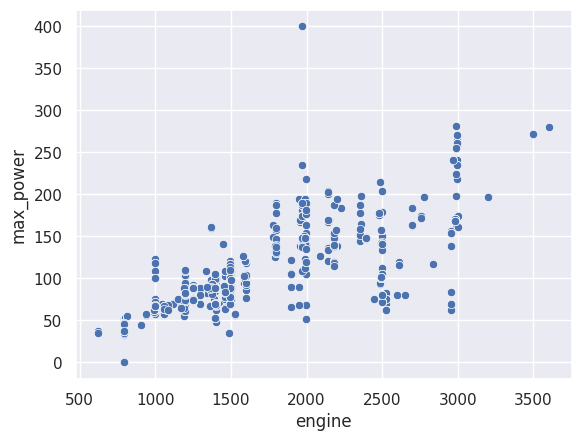

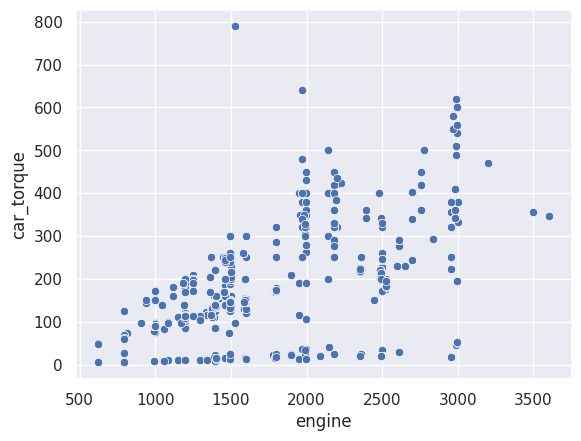

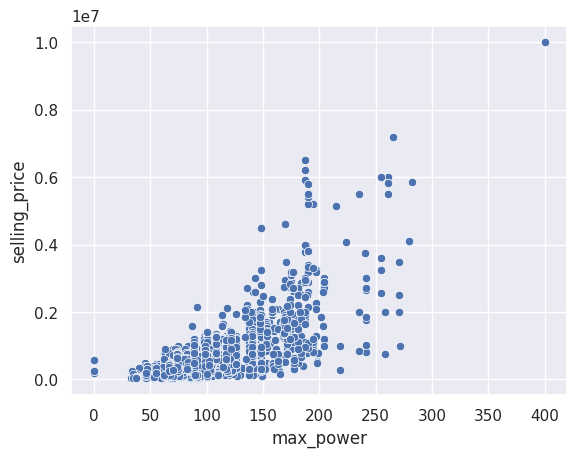

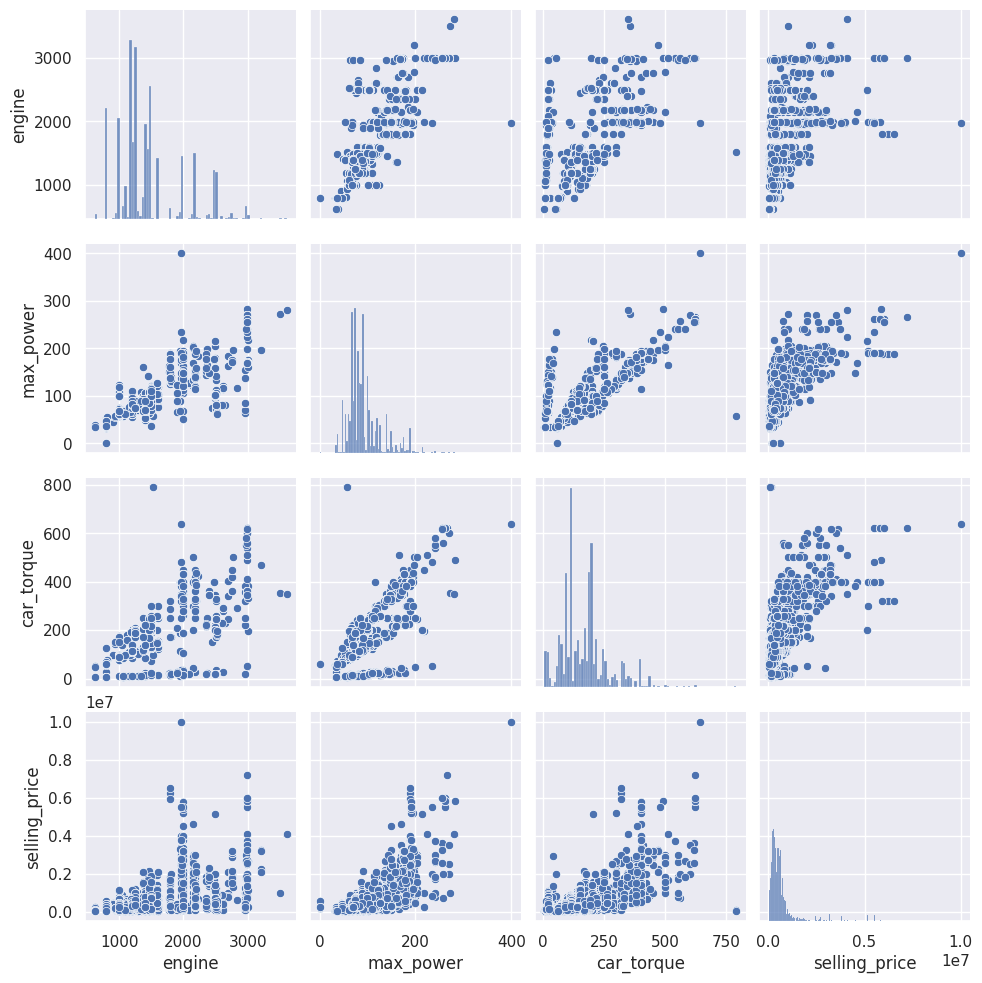

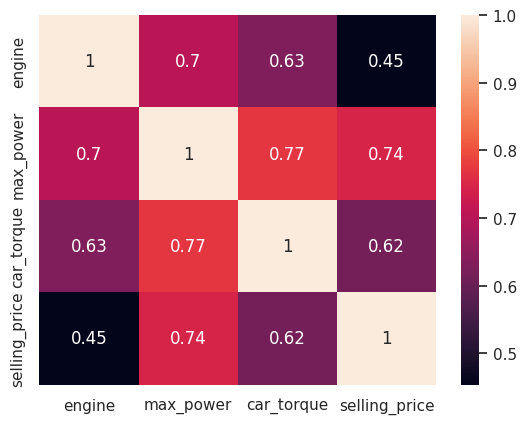

In [61]:

sns.scatterplot(data=df, x="engine", y="max_power")
plt.show()

sns.scatterplot(data=df, x="engine", y="car_torque")
plt.show()

sns.scatterplot(data=df, x="max_power", y="selling_price")
plt.show()

sns.pairplot(df[["engine","max_power","car_torque","selling_price"]])
plt.show()

sns.heatmap(df[["engine","max_power","car_torque","selling_price"]].corr(), annot=True)
plt.show()



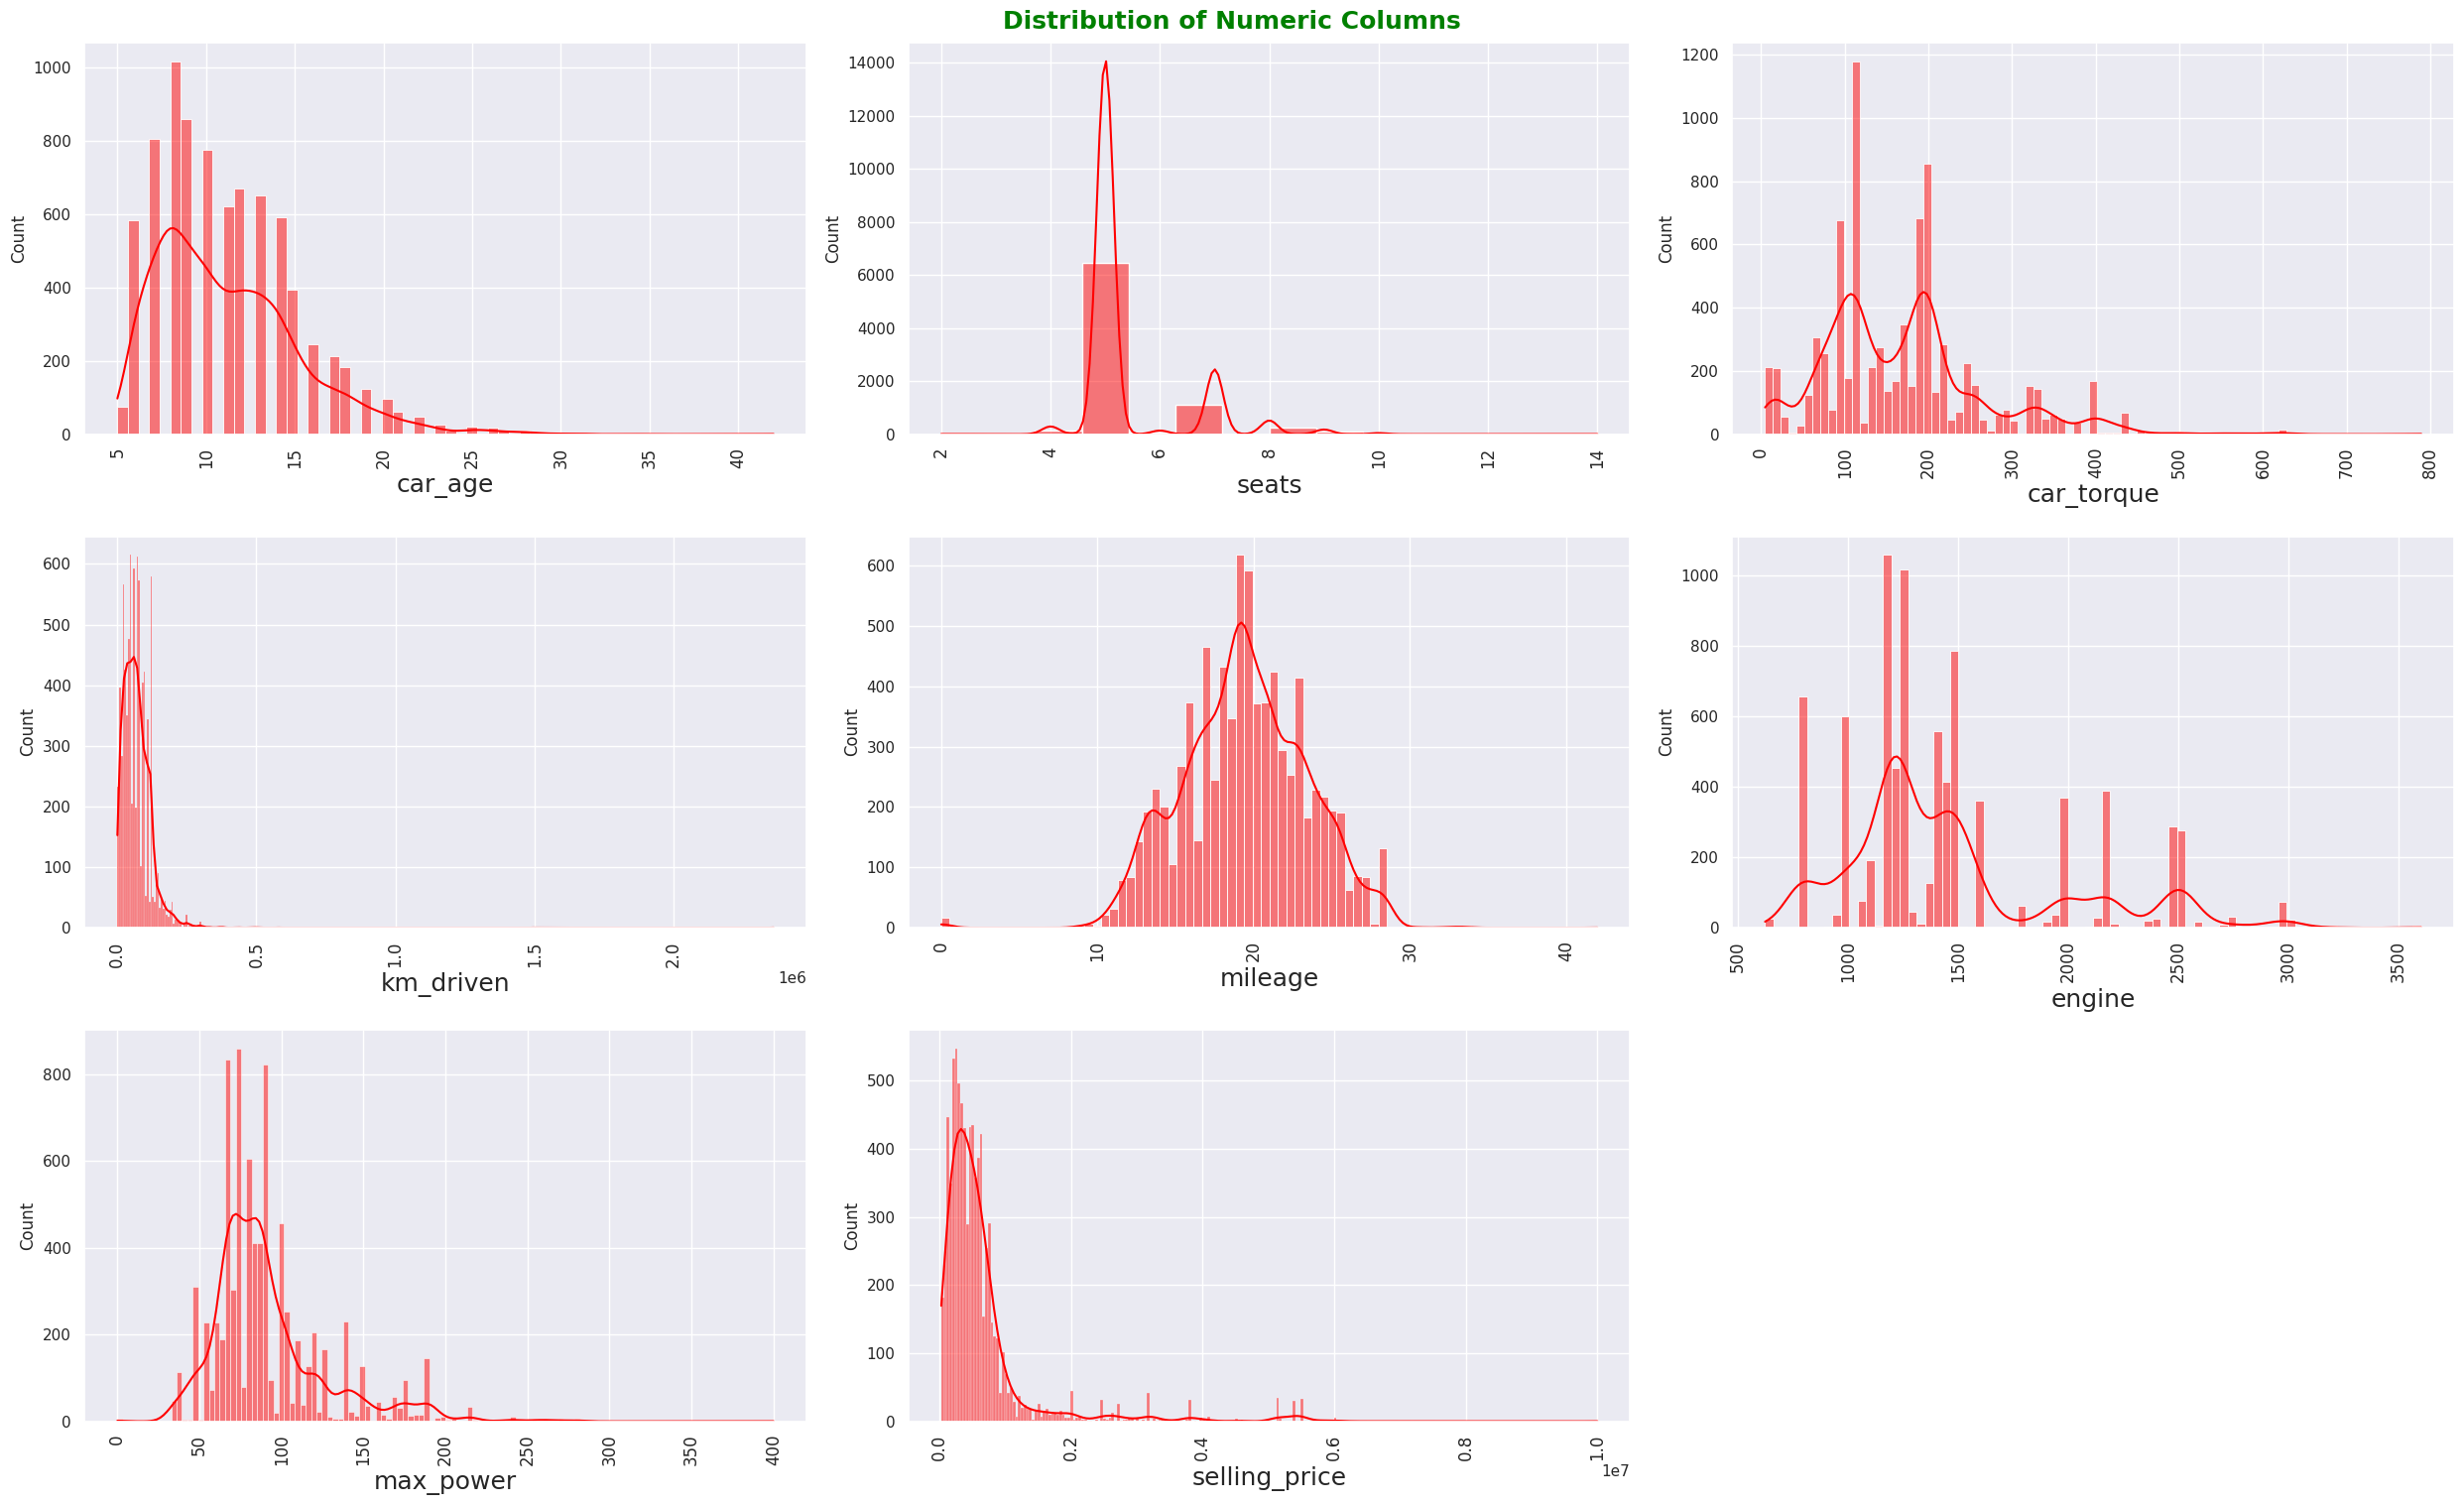

In [89]:
plt.figure(figsize=(25,15))
for i, col in enumerate(num, 1):
    plt.subplot(3,3,i)
    sns.histplot(data=df, x=col, color='red', kde=True)
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel(col, fontsize=18)
    plt.tight_layout()
plt.suptitle('Distribution of Numeric Columns', y=1.01, color='green', fontsize=18, weight='bold')
plt.show();


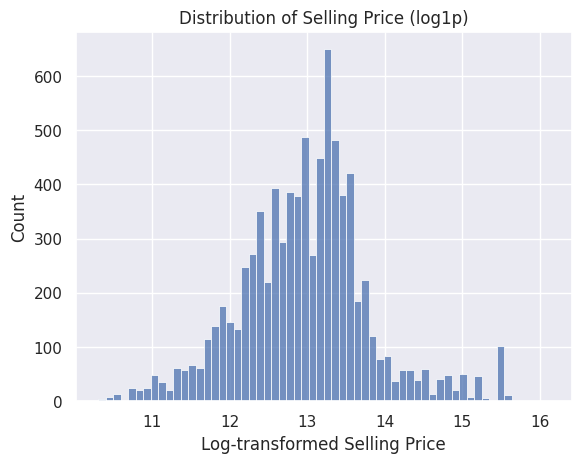

In [62]:
sns.histplot(x=np.log1p(df['selling_price']))
plt.xlabel("Log-transformed Selling Price")
plt.title("Distribution of Selling Price (log1p)")
plt.show()

# Scaling Data

In [63]:
import numpy as np
from numpy.linalg import inv, svd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Prepare data
X = df[['car_age','km_driven','seats','mileage','engine','max_power','car_torque',
        'fuel_Diesel','fuel_LPG','fuel_Petrol','seller_type_Individual',
        'seller_type_Trustmark_Dealer','transmission_Manual',
        'owner_Fourth_and_Above_Owner','owner_Second_Owner',
        'owner_Test_Drive_Car','owner_Third_Owner','brand_enc','model_enc']].values


# X = df[['car_age','km_driven','seats','mileage','engine','max_power','car_torque',
#         'fuel_Diesel','fuel_LPG','fuel_Petrol','seller_type_Individual',
#         'seller_type_Trustmark_Dealer','transmission_Manual',
#         'owner_Fourth_and_Above_Owner','owner_Second_Owner',
#         'owner_Third_Owner']].values

y = df['selling_price'].values

# Log transform target
y_log = np.log1p(y).reshape(-1, 1)

# Scale features
sx = StandardScaler()
X_scaled = sx.fit_transform(X)



# Spliting Data

In [64]:
# Split data
X_train, X_test, y_train_log, y_test_log, y_train, y_test = train_test_split(
    X_scaled, y_log, y.reshape(-1, 1), test_size=0.2, random_state=42
)



# OLS Regression

In [65]:

# Add bias term
X_b_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_b_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# # θ = (XᵀX)⁻¹ Xᵀ y
theta_ols = inv(X_b_train.T @ X_b_train) @ X_b_train.T @ y_train_log
y_pred_train_ols = X_b_train @ theta_ols
y_pred_test_ols = X_b_test @ theta_ols

# # Convert from log space
y_pred_train_ols_orig = np.expm1(y_pred_train_ols)
y_pred_test_ols_orig = np.expm1(y_pred_test_ols)

print(f"Train R²:  {r2_score(y_train, y_pred_train_ols_orig):.6f}")
print(f"Test R²:   {r2_score(y_test, y_pred_test_ols_orig):.6f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_ols_orig)):,.0f}")
print(f"Test RMSE:  {np.sqrt(mean_squared_error(y_test, y_pred_test_ols_orig)):,.0f}")
print(f"\nOLS Coefficients (first 5): {theta_ols.flatten()[:5]}")


Train R²:  0.840818
Test R²:   0.861792
Train RMSE: 321,314
Test RMSE:  300,988

OLS Coefficients (first 5): [12.97358894 -0.44807648 -0.01688819  0.02330145  0.03377843]


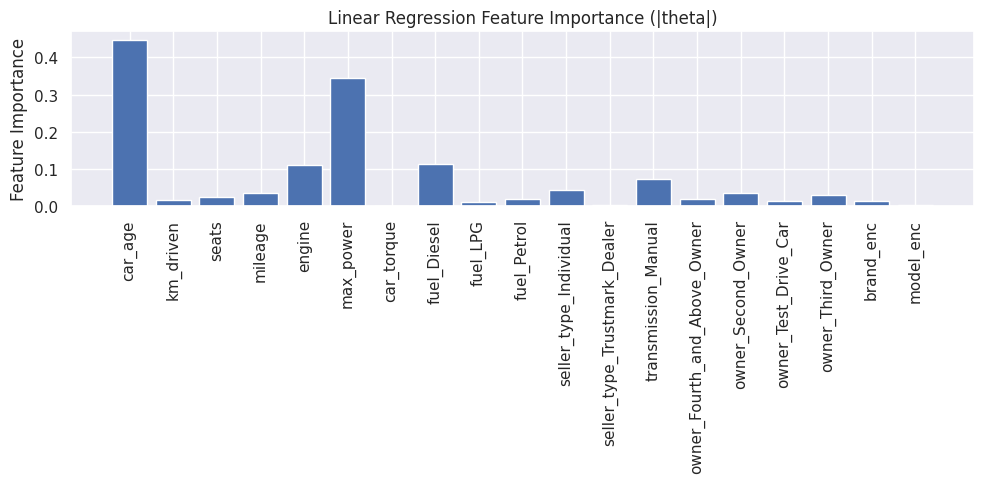

In [66]:
import numpy as np
import matplotlib.pyplot as plt

features = ['car_age','km_driven','seats','mileage','engine','max_power','car_torque',
        'fuel_Diesel','fuel_LPG','fuel_Petrol','seller_type_Individual',
        'seller_type_Trustmark_Dealer','transmission_Manual',
        'owner_Fourth_and_Above_Owner','owner_Second_Owner',
        'owner_Test_Drive_Car','owner_Third_Owner','brand_enc','model_enc']

theta_no_bias = theta_ols.flatten()[1:]
importance = np.abs(theta_no_bias)

plt.figure(figsize=(10,5))
plt.bar(features, importance)
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")
plt.title("Linear Regression Feature Importance (|theta|)")
plt.tight_layout()
plt.show()


# OLS Visualization

In [67]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X_test[:,0],
    y=X_test[:,1],
    z=y_test.flatten(),
    mode='markers',
    marker=dict(size=4, color='blue', opacity=0.6),
    name='Actual'
))

fig.add_trace(go.Scatter3d(
    x=X_test[:,0],
    y=X_test[:,1],
    z=y_pred_test_ols_orig.flatten(),
    mode='markers',
    marker=dict(size=4, color='red', symbol='x', opacity=0.6),
    name='Predicted'
))

fig.update_layout(
    scene=dict(
        xaxis_title='car_age',
        yaxis_title='km_driven',
        zaxis_title='selling_price'
    ),
    width=800,
    height=600,
    title="3D Plot: Actual vs Predicted Selling Price"
)

fig.show()


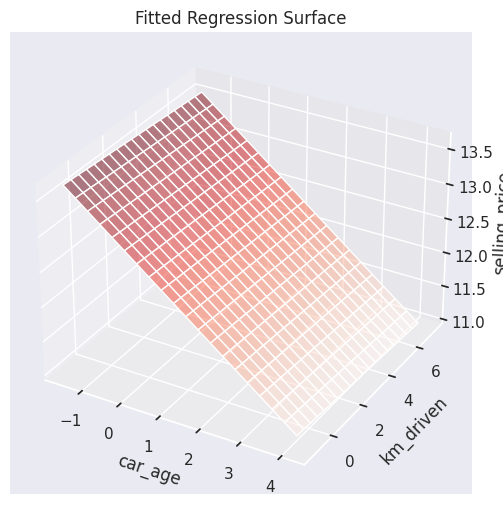

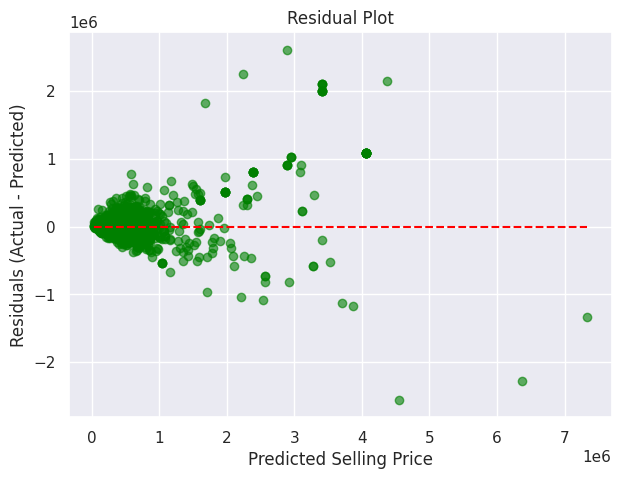

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


x = X_test[:,0]  # car_age
y = X_test[:,1]  # km_driven

theta0 = theta_ols[0,0]
theta1 = theta_ols[1,0]
theta2 = theta_ols[2,0]

x_range = np.linspace(x.min(), x.max(), 20)
y_range = np.linspace(y.min(), y.max(), 20)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_grid = theta0 + theta1*x_grid + theta2*y_grid

# 3D Fitted surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, cmap='Reds')
ax.set_xlabel("car_age")
ax.set_ylabel("km_driven")
ax.set_zlabel("selling_price")
ax.set_title("Fitted Regression Surface")
plt.show()

# Residual plot
residuals = y_test.flatten() - y_pred_test_ols_orig.flatten()
plt.figure(figsize=(7,5))
plt.scatter(y_pred_test_ols_orig.flatten(), residuals, alpha=0.6, color='green')
plt.hlines(0, y_pred_test_ols_orig.min(), y_pred_test_ols_orig.max(), colors='red', linestyles='dashed')
plt.xlabel("Predicted Selling Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


# SVD

In [69]:



# Solve X_b θ = y using SVD
# X = U Σ Vᵀ
# θ = V Σ⁻¹ Uᵀ y
U, S, Vt = svd(X_b_train, full_matrices=False)
theta_svd = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T @ y_train_log
y_pred_train_svd = X_b_train @ theta_svd
y_pred_test_svd = X_b_test @ theta_svd




# Convert from log space
y_pred_train_svd_orig = np.expm1(y_pred_train_svd)
y_pred_test_svd_orig = np.expm1(y_pred_test_svd)

print(f"Train R²:  {r2_score(y_train, y_pred_train_svd_orig):.6f}")
print(f"Test R²:   {r2_score(y_test, y_pred_test_svd_orig):.6f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_svd_orig)):,.0f}")
print(f"Test RMSE:  {np.sqrt(mean_squared_error(y_test, y_pred_test_svd_orig)):,.0f}")
print(f"\nSVD Coefficients (first 5): {theta_svd.flatten()[:5]}")

print("\n[3] SVD Analysis")
print("-" * 80)

print(f"Matrix dimensions: {X_b_train.shape}")
print(f"Number of singular values: {len(S)}")
print(f"Condition number: {S[0] / S[-1]:.2e}")

print(f"\nTop 5 Singular Values:")
for i in range(min(5, len(S))):
    print(f"  σ_{i+1} = {S[i]:.6f}")

print(f"\nSmallest 5 Singular Values:")
for i in range(max(0, len(S)-5), len(S)):
    print(f"  σ_{i+1} = {S[i]:.6e}")

# Coefficient comparison
coef_diff = np.abs(theta_ols.flatten() - theta_svd.flatten())
print(f"\nCoefficient Comparison:")
print(f"Max difference: {np.max(coef_diff):.2e}")
print(f"Mean difference: {np.mean(coef_diff):.2e}")
print(f"Coefficients match: {np.allclose(theta_ols, theta_svd)}")

print("\n[4] Benefits of SVD")
print("-" * 80)
print(" Numerical Stability: Avoids computing XᵀX which can amplify errors")
print("Handles ill-conditioned matrices better than normal equations")
print("Reveals matrix rank and condition number")
print(f"Your condition number: {S[0]/S[-1]:.2e}")
if S[0]/S[-1] > 1e10:
    print("Matrix is ill-conditioned - SVD is recommended!")
else:
    print("Matrix is well-conditioned - both methods work well")




Train R²:  0.840818
Test R²:   0.861792
Train RMSE: 321,314
Test RMSE:  300,988

SVD Coefficients (first 5): [12.97358894 -0.44807648 -0.01688819  0.02330145  0.03377843]

[3] SVD Analysis
--------------------------------------------------------------------------------
Matrix dimensions: (6502, 20)
Number of singular values: 20
Condition number: 1.69e+01

Top 5 Singular Values:
  σ_1 = 159.844711
  σ_2 = 128.140789
  σ_3 = 108.043896
  σ_4 = 88.496669
  σ_5 = 86.200052

Smallest 5 Singular Values:
  σ_16 = 5.086484e+01
  σ_17 = 3.983640e+01
  σ_18 = 3.577582e+01
  σ_19 = 2.556584e+01
  σ_20 = 9.484597e+00

Coefficient Comparison:
Max difference: 9.10e-14
Mean difference: 8.61e-15
Coefficients match: True

[4] Benefits of SVD
--------------------------------------------------------------------------------
 Numerical Stability: Avoids computing XᵀX which can amplify errors
Handles ill-conditioned matrices better than normal equations
Reveals matrix rank and condition number
Your conditio

# SVD Visualiztion

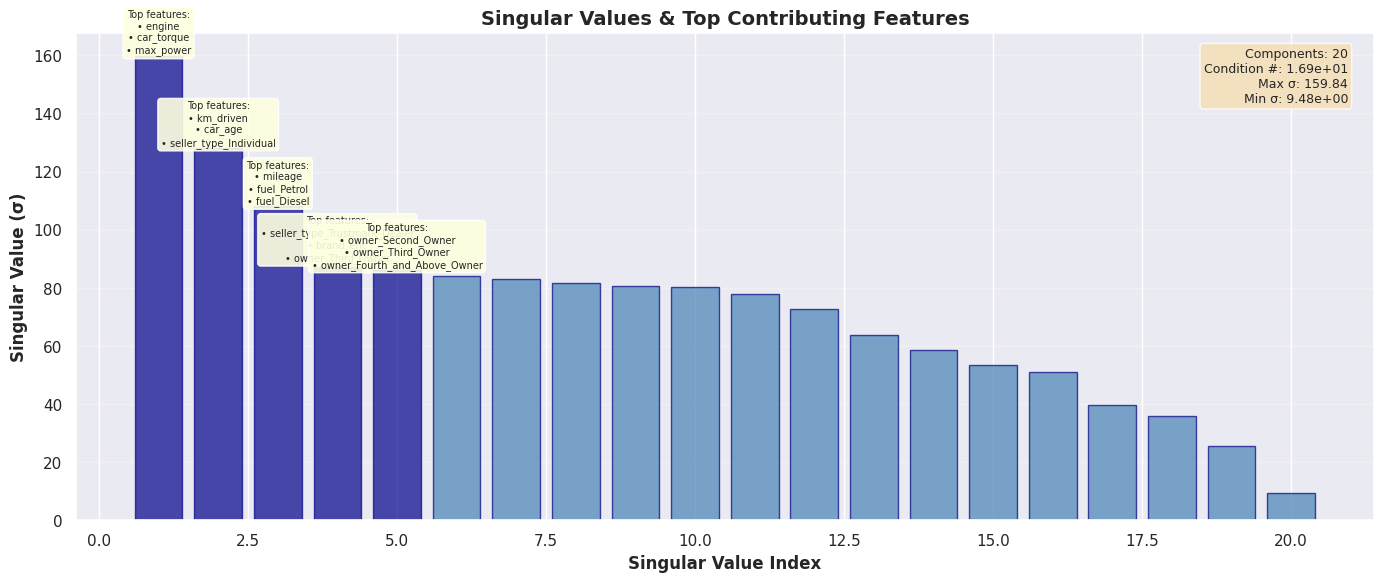

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Feature names
feature_names = ["Intercept", 'car_age', 'km_driven', 'seats', 'mileage', 'engine',
                 'max_power', 'car_torque', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
                 'seller_type_Individual', 'seller_type_Trustmark_Dealer',
                 'transmission_Manual', 'owner_Fourth_and_Above_Owner',
                 'owner_Second_Owner', 'owner_Test_Drive_Car', 'owner_Third_Owner',
                 'brand_enc', 'model_enc']
# feature_names=["Intercept",'car_age','km_driven','seats','mileage','engine','max_power','car_torque',
#         'fuel_Diesel','fuel_LPG','fuel_Petrol','seller_type_Individual',
#         'seller_type_Trustmark_Dealer','transmission_Manual',
#         'owner_Fourth_and_Above_Owner','owner_Second_Owner',
#         'owner_Third_Owner']

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Bar plot
indices = np.arange(1, len(S) + 1)
bars = ax.bar(indices, S, color='steelblue', alpha=0.7, edgecolor='navy')

# Highlight top 5
for i in range(min(5, len(S))):
    bars[i].set_color('darkblue')

ax.set_xlabel('Singular Value Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Singular Value (σ)', fontsize=12, fontweight='bold')
ax.set_title('Singular Values & Top Contributing Features', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Annotate top 5 components with their most important features
for i in range(min(5, len(S))):
    # Get top 3 features for this component
    weights = np.abs(Vt[i, :])
    top_idx = np.argsort(weights)[-3:][::-1]

    text = "Top features:\n"
    for idx in top_idx:
        text += f"• {feature_names[idx]}\n"

    ax.text(i + 1, S[i], text.strip(), ha='center', va='bottom', fontsize=7,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

# Summary box
summary = (f'Components: {len(S)}\n'
           f'Condition #: {S[0]/S[-1]:.2e}\n'
           f'Max σ: {S[0]:.2f}\n'
           f'Min σ: {S[-1]:.2e}')

ax.text(0.98, 0.97, summary, transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=9)

plt.tight_layout()
plt.show()

# Gradient Descent

In [71]:

def gradient_descent(X, y, lr=0.001, epochs=1000):

    m, n = X.shape
    theta = np.zeros((n, 1))
    losses = []

    for i in range(epochs):
        y_pred = X @ theta
        error = y_pred - y
        grad = (1/m) * X.T @ error
        theta -= lr * grad
        loss = mean_squared_error(y, y_pred)
        losses.append(loss)

    return theta, losses

# Experiment with different learning rates
learning_rates = [0.001, 0.01, 0.05, 0.1]
epochs = 1000
results = {}

print("\n[1] Testing Different Learning Rates")
print("-" * 80)

for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    theta_gd, losses = gradient_descent(X_b_train, y_train_log, lr=lr, epochs=epochs)

    y_pred_train_gd = X_b_train @ theta_gd
    y_pred_test_gd = X_b_test @ theta_gd

    y_pred_train_gd_orig = np.expm1(y_pred_train_gd)
    y_pred_test_gd_orig = np.expm1(y_pred_test_gd)

    train_r2 = r2_score(y_train, y_pred_train_gd_orig)
    test_r2 = r2_score(y_test, y_pred_test_gd_orig)

    results[lr] = {
        'theta': theta_gd,
        'losses': losses,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

    print(f"  Final Loss: {losses[-1]:.6f}")
    print(f"  Train R²: {train_r2:.6f}")
    print(f"  Test R²: {test_r2:.6f}")
    print(f"  Coefficients (first 5): {theta_gd.flatten()[:5]}")


[1] Testing Different Learning Rates
--------------------------------------------------------------------------------

Learning Rate: 0.001
  Final Loss: 22.922130
  Train R²: -0.608053
  Test R²: -0.598632
  Coefficients (first 5): [ 8.20232303e+00 -2.65314746e-01 -6.06865691e-02  4.19187032e-03
  1.05415734e-02]

Learning Rate: 0.01
  Final Loss: 0.093992
  Train R²: 0.841448
  Test R²: 0.850467
  Coefficients (first 5): [12.9729164  -0.44267357 -0.01594597  0.01511336  0.0349716 ]

Learning Rate: 0.05
  Final Loss: 0.093399
  Train R²: 0.840939
  Test R²: 0.861581
  Coefficients (first 5): [12.97358419 -0.44789935 -0.01685972  0.02309657  0.03338583]

Learning Rate: 0.1
  Final Loss: 0.093374
  Train R²: 0.840868
  Test R²: 0.861747
  Coefficients (first 5): [12.97358686 -0.44798839 -0.01687899  0.02330808  0.03351734]


# Gradinet Descent Visualization

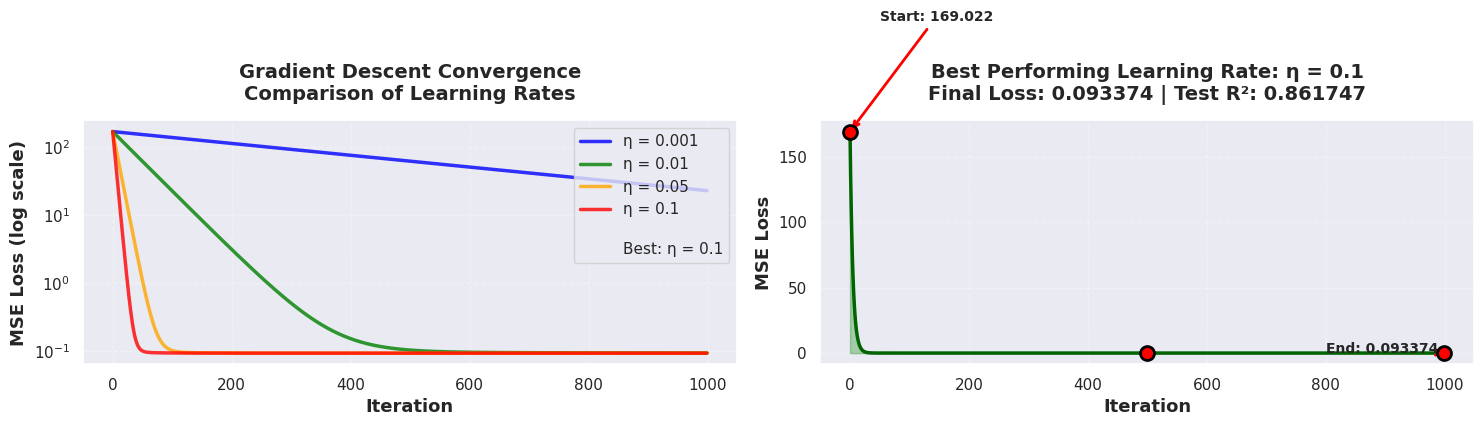

✓ Plot saved as 'gradient_descent_convergence.png'

Convergence Summary:
  Best Learning Rate: 0.1
  Initial Loss: 169.021663
  Final Loss: 0.093374
  Loss Reduction: 99.94%
  Test R²: 0.861747


In [72]:
import numpy as np
import matplotlib.pyplot as plt


learning_rates = [0.001, 0.01, 0.05, 0.1]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


colors = ['blue', 'green', 'orange', 'red']
for lr, color in zip(learning_rates, colors):
    ax1.plot(results[lr]['losses'], label=f'η = {lr}',
             linewidth=2.5, color=color, alpha=0.8)

ax1.set_xlabel("Iteration", fontsize=13, fontweight='bold')
ax1.set_ylabel("MSE Loss (log scale)", fontsize=13, fontweight='bold')
ax1.set_title("Gradient Descent Convergence\nComparison of Learning Rates",
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_yscale('log')

# Add annotation for best learning rate
best_lr = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_idx = learning_rates.index(best_lr)
ax1.plot([], [], ' ', label=f'\nBest: η = {best_lr}')
ax1.legend(fontsize=11, loc='upper right')

# ============================================
# Plot 2: Best Learning Rate - Linear Scale
# ============================================
best_losses = results[best_lr]['losses']
ax2.plot(best_losses, color='darkgreen', linewidth=2.5)
ax2.fill_between(range(len(best_losses)), best_losses, alpha=0.3, color='green')

ax2.set_xlabel("Iteration", fontsize=13, fontweight='bold')
ax2.set_ylabel("MSE Loss", fontsize=13, fontweight='bold')
ax2.set_title(f"Best Performing Learning Rate: η = {best_lr}\n"
              f"Final Loss: {best_losses[-1]:.6f} | Test R²: {results[best_lr]['test_r2']:.6f}",
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')

# Add markers for key points
convergence_point = len(best_losses) // 2
ax2.scatter([0, convergence_point, len(best_losses)-1],
           [best_losses[0], best_losses[convergence_point], best_losses[-1]],
           s=100, c='red', zorder=5, edgecolors='black', linewidth=2)

# Annotations
ax2.annotate(f'Start: {best_losses[0]:.3f}',
            xy=(0, best_losses[0]), xytext=(50, best_losses[0]*1.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, fontweight='bold')

ax2.annotate(f'End: {best_losses[-1]:.6f}',
            xy=(len(best_losses)-1, best_losses[-1]),
            xytext=(len(best_losses)-200, best_losses[-1]*2),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('gradient_descent_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Plot saved as 'gradient_descent_convergence.png'")
print(f"\nConvergence Summary:")
print(f"  Best Learning Rate: {best_lr}")
print(f"  Initial Loss: {best_losses[0]:.6f}")
print(f"  Final Loss: {best_losses[-1]:.6f}")
print(f"  Loss Reduction: {(1 - best_losses[-1]/best_losses[0])*100:.2f}%")
print(f"  Test R²: {results[best_lr]['test_r2']:.6f}")

#PCA

PCA VIA SVD
Dataset shape: (8128, 19)

Variance Explained by Principal Components:
PC 1:  99.94%  (Cumulative:  99.94%)
PC 2:   0.05%  (Cumulative:  99.99%)
PC 3:   0.00%  (Cumulative: 100.00%)
PC 4:   0.00%  (Cumulative: 100.00%)
PC 5:   0.00%  (Cumulative: 100.00%)
PC 6:   0.00%  (Cumulative: 100.00%)
PC 7:   0.00%  (Cumulative: 100.00%)
PC 8:   0.00%  (Cumulative: 100.00%)
PC 9:   0.00%  (Cumulative: 100.00%)
PC10:   0.00%  (Cumulative: 100.00%)

✓ 1 components explain 95% of variance


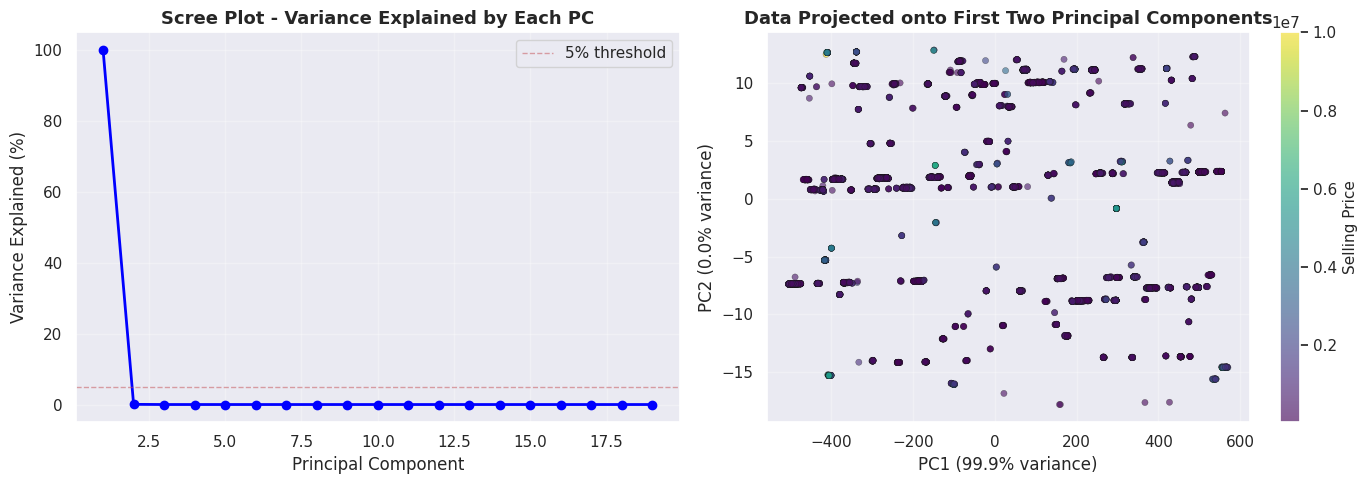


✓ Plots saved as 'pca_plots.png'
✅ PCA Analysis Complete!


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Feature columns
feature_cols = ['car_age','km_driven','seats','mileage','engine','max_power','car_torque',
                'fuel_Diesel','fuel_LPG','fuel_Petrol','seller_type_Individual',
                'seller_type_Trustmark_Dealer','transmission_Manual',
                'owner_Fourth_and_Above_Owner','owner_Second_Owner',
                'owner_Test_Drive_Car','owner_Third_Owner','brand_enc','model_enc']

numeric_cols = ['car_age','km_driven','seats','mileage','engine','max_power','car_torque']

# Prepare data
X_df = df[feature_cols].copy()
scaler = StandardScaler()
X_df[numeric_cols] = scaler.fit_transform(X_df[numeric_cols])

X = X_df.values
y = df['selling_price'].values

print("="*70)
print("PCA VIA SVD")
print("="*70)
print(f"Dataset shape: {X.shape}")

# ===============================================================
# PCA via SVD
# ===============================================================
# Center the data
X_centered = X - np.mean(X, axis=0)

# Perform SVD: X = U Σ Vᵀ
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Explained variance
explained_variance = (S**2) / (X.shape[0] - 1)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\nVariance Explained by Principal Components:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"PC{i+1:2d}: {explained_variance_ratio[i]*100:6.2f}%  "
          f"(Cumulative: {cumulative_variance[i]*100:6.2f}%)")

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\n✓ {n_components_95} components explain 95% of variance")

# ===============================================================
# Visualizations
# ===============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scree Plot
ax1.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio * 100, 'o-', color='blue', linewidth=2, markersize=6)
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained (%)', fontsize=12)
ax1.set_title('Scree Plot - Variance Explained by Each PC', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=5, color='r', linestyle='--', alpha=0.5, linewidth=1, label='5% threshold')
ax1.legend()

# Plot 2: 2D Projection onto First Two Principal Components
X_2D = X_centered @ Vt[:2, :].T
scatter = ax2.scatter(X_2D[:, 0], X_2D[:, 1], c=y,
                     cmap='viridis', alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
ax2.set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% variance)', fontsize=12)
ax2.set_title('Data Projected onto First Two Principal Components', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Selling Price', fontsize=11)

plt.tight_layout()
plt.savefig('pca_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plots saved as 'pca_plots.png'")
print("✅ PCA Analysis Complete!")

# Final Results

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred_train_ols_orig = np.expm1(X_b_train @ theta_ols)
y_pred_test_ols_orig  = np.expm1(X_b_test  @ theta_ols)

y_pred_train_svd_orig = np.expm1(X_b_train @ theta_svd)
y_pred_test_svd_orig  = np.expm1(X_b_test  @ theta_svd)

y_pred_train_gd_orig = np.expm1(X_b_train @ results[lr]['theta'])
y_pred_test_gd_orig  = np.expm1(X_b_test  @ results[lr]['theta'])

# ===============================================================
# Final Comparison Table
# ===============================================================
print("\n[3] Final Comparison: OLS vs SVD vs Gradient Descent")
print("="*80)
print(f"{'Method':<30} {'Train R²':<10} {'Test R²':<10} {'Train RMSE':<15} {'Test RMSE':<15}")
print("-"*80)
print(f"{'OLS (Normal Equations)':<30} "
      f"{r2_score(y_train, y_pred_train_ols_orig):>10.6f} "
      f"{r2_score(y_test,  y_pred_test_ols_orig):>10.6f} "
      f"{np.sqrt(mean_squared_error(y_train, y_pred_train_ols_orig)):>12,.0f} "
      f"{np.sqrt(mean_squared_error(y_test,  y_pred_test_ols_orig)):>12,.0f}")

print(f"{'SVD-Based':<30} "
      f"{r2_score(y_train, y_pred_train_svd_orig):>10.6f} "
      f"{r2_score(y_test,  y_pred_test_svd_orig):>10.6f} "
      f"{np.sqrt(mean_squared_error(y_train, y_pred_train_svd_orig)):>12,.0f} "
      f"{np.sqrt(mean_squared_error(y_test,  y_pred_test_svd_orig)):>12,.0f}")

print(f"{'Gradient Descent (η={best_lr})':<30} "
      f"{r2_score(y_train, y_pred_train_gd_orig):>10.6f} "
      f"{r2_score(y_test,  y_pred_test_gd_orig):>10.6f} "
      f"{np.sqrt(mean_squared_error(y_train, y_pred_train_gd_orig)):>12,.0f} "
      f"{np.sqrt(mean_squared_error(y_test,  y_pred_test_gd_orig)):>12,.0f}")

# ===============================================================
# Key Insights
# ===============================================================
print("\n[4] Key Insights")
print("-"*80)
print("• OLS and SVD produce nearly identical results (numerical precision).")
print("• SVD is more stable for ill-conditioned matrices.")
print(f"• Best learning rate (GD): {best_lr} achieved Test R² = {r2_score(y_test, y_pred_test_gd_orig):.6f}")
print(f"• Gradient Descent converged in {epochs} iterations.")
print("• All three methods achieve similar predictive performance.")
print("• Choice depends on data size, conditioning, and memory constraints.")

print("\n✅ Analysis Complete!")


[3] Final Comparison: OLS vs SVD vs Gradient Descent
Method                         Train R²   Test R²    Train RMSE      Test RMSE      
--------------------------------------------------------------------------------
OLS (Normal Equations)           0.840818   0.861792      321,314      300,988
SVD-Based                        0.840818   0.861792      321,314      300,988
Gradient Descent (η={best_lr})   0.840868   0.861747      321,264      301,035

[4] Key Insights
--------------------------------------------------------------------------------
• OLS and SVD produce nearly identical results (numerical precision).
• SVD is more stable for ill-conditioned matrices.
• Best learning rate (GD): 0.1 achieved Test R² = 0.861747
• Gradient Descent converged in 1000 iterations.
• All three methods achieve similar predictive performance.
• Choice depends on data size, conditioning, and memory constraints.

✅ Analysis Complete!


In [44]:

# ===============================================================
# 6. Summary
# ===============================================================

print("=== Summary ===")
print("OLS Coefficients:", theta_ols.flatten())
print("SVD Coefficients:", theta_svd.flatten())
print("GD Coefficients :", theta_gd.flatten())
# print("PCA Explained Variance:", pca.explained_variance_ratio_)


=== Summary ===
OLS Coefficients: [ 1.29735889e+01 -4.48076482e-01 -1.68881931e-02  2.33014543e-02
  3.37784258e-02  1.10446060e-01  3.43825361e-01 -5.77232190e-04
  1.11993560e-01  1.11525909e-02  1.93645295e-02 -4.33318315e-02
  2.52500978e-03 -7.23796658e-02 -1.84622545e-02 -3.56777563e-02
  1.30536878e-02 -2.89570503e-02 -1.21629125e-02  3.17937202e-03]
SVD Coefficients: [ 1.29735889e+01 -4.48076482e-01 -1.68881931e-02  2.33014543e-02
  3.37784258e-02  1.10446060e-01  3.43825361e-01 -5.77232190e-04
  1.11993560e-01  1.11525909e-02  1.93645295e-02 -4.33318315e-02
  2.52500978e-03 -7.23796658e-02 -1.84622545e-02 -3.56777563e-02
  1.30536878e-02 -2.89570503e-02 -1.21629125e-02  3.17937202e-03]
GD Coefficients : [ 1.29735869e+01 -4.47988388e-01 -1.68789924e-02  2.33080821e-02
  3.35173410e-02  1.10326965e-01  3.43781258e-01 -2.22126375e-04
  9.46727438e-02  8.77495719e-03  2.18247686e-03 -4.34186393e-02
  2.55421718e-03 -7.23283272e-02 -1.85116440e-02 -3.56870441e-02
  1.30502005e-02 -